In [1]:
import sys
sys.path.append('../src')

import torch
import torchvision
import torchvision.datasets as datasets
import numpy as np

import matplotlib.pyplot as plt
from modules import IDC
from utils import get_synthetic_dataset, plot_synthetic_dataset, clustering_accuracy
from trainer import idc_trainer, device

import warnings
warnings.filterwarnings('ignore')

2024-02-11 17:49:12.477587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 17:49:12.604779: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 17:49:14.383085: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.6/lib64:/usr/local/cuda-12.2/lib64
2024-02-11 17:49:14.383176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror:

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_X = mnist_trainset.data.reshape(-1, 784) / 255.
mnist_y = mnist_trainset.targets

subset_size_per_class = 1000
classes = torch.unique(mnist_y)
subset_indices = []
for class_label in classes:
    indices = (mnist_y == class_label).nonzero().squeeze()
    subset_indices.extend(indices[:subset_size_per_class])

import random
random.seed(SEED)
random.shuffle(subset_indices)

mnist_X_subset = mnist_X[subset_indices]
mnist_y_subset = mnist_y[subset_indices]

In [4]:
data_input_dim = 784
ae_layer_dims = [784, 512, 512, 2048, 10]
gnn_hidden_dim = 784
cluster_hidden_dim = 2048
nb_classes = 10

idc = IDC(data_input_dim, ae_layer_dims, gnn_hidden_dim, cluster_hidden_dim, nb_classes)

In [5]:
ae_gnn_config_train = {
    "batch_size":100, 
    "lr":1e-3,
    "local_gates_lmbd": 100,
    "reg_lmbd": 100,
    "eps": 1e-1,
    
    "epochs":100,
    "end_pretrain_epoch": 10,
}

clust_config_train = {
    "batch_size":100, 
    "lr_cluster_head": 1e-2,
    "lr_aux": 1e-1,
    "lr_zg": 1e-1,
    "gamma": 4,
    "global_gates_lmbd": 10,
    "tau": 100,
    
    "epochs": 400,
    "end_pretrain_epoch": 100
}

training_result = idc_trainer(idc, mnist_X_subset, ae_gnn_config_train, clust_config_train)

--------------------------------
Stage One Starting :


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]


Stage One Finishing
--------------------------------

--------------------------------
Stage Two Starting :


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [1:26:22<00:00, 12.96s/it]

Stage Two Finishing
--------------------------------


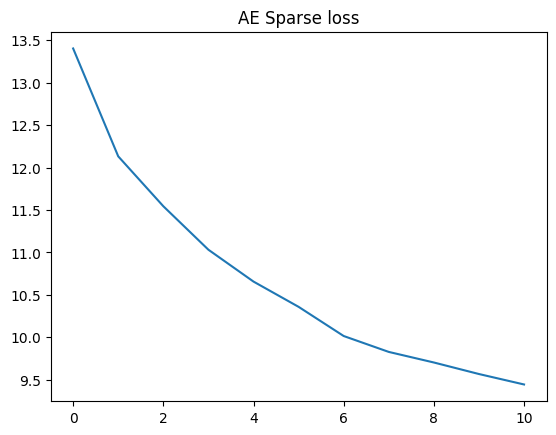

In [6]:
plt.plot(training_result["stage_one"]["ae_sparse_losses"])
plt.title("AE Sparse loss")
plt.show()

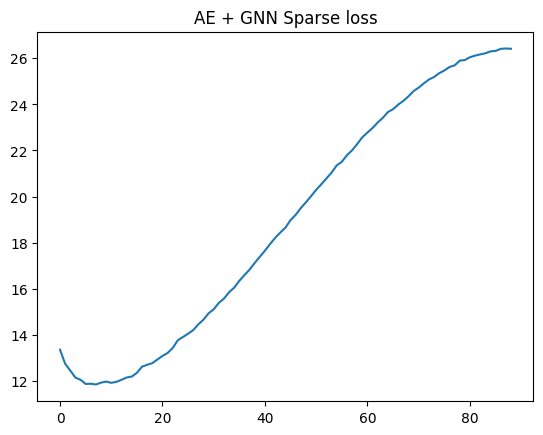

In [7]:
plt.plot(training_result["stage_one"]["ae_gnn_sparse_losses"])
plt.title("AE + GNN Sparse loss")
plt.show()

------------------------------
AE Fine-tuned , display for X
------------------------------


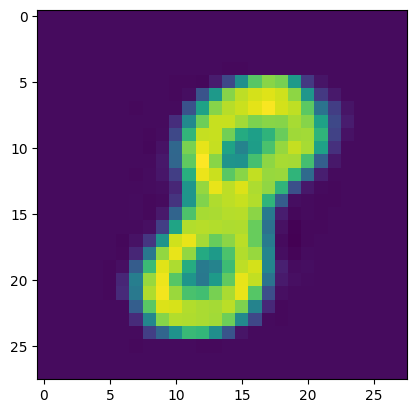

------------------------------
AE Fine-tuned , display for X_Z
------------------------------


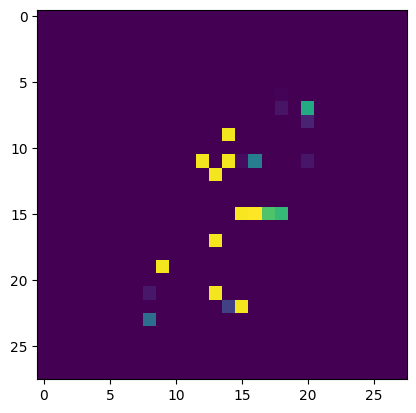

------------------------------
AE Fine-tuned , display for X_Z_HAT
------------------------------


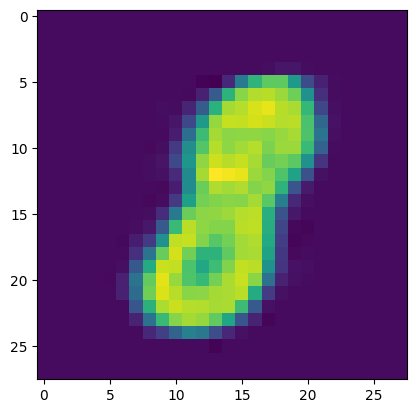

In [15]:
idx = 5
with torch.no_grad():
    X = mnist_X_subset.to(device)
    X_Z ,z , _ = idc.gnn(X)
    X_z_hat = idc.ae(X_Z)
    X_hat = idc.ae(X)

    print("------------------------------")
    print("AE Fine-tuned , display for X")
    print("------------------------------")
    plt.imshow(X_hat[idx].cpu().view(28, 28))
    plt.show()

    print("------------------------------")
    print("AE Fine-tuned , display for X_Z")
    print("------------------------------")
    plt.imshow(X_Z[idx].cpu().view(28, 28))
    plt.show()
    
    
    print("------------------------------")
    print("AE Fine-tuned , display for X_Z_HAT")
    print("------------------------------")
    plt.imshow(X_z_hat[idx].cpu().view(28, 28))
    plt.show()

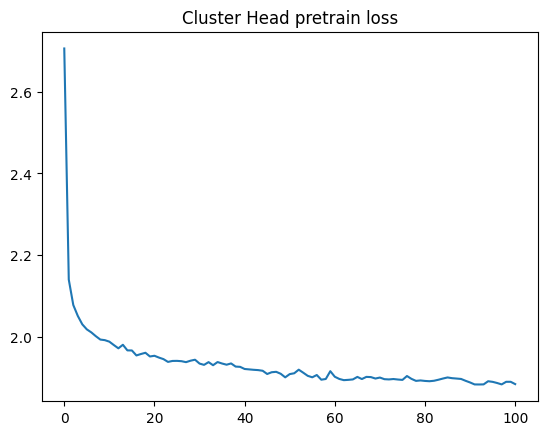

In [9]:
plt.plot(training_result["stage_two"]["clust_head_pretrain_losses"])
plt.title("Cluster Head pretrain loss")
plt.show()

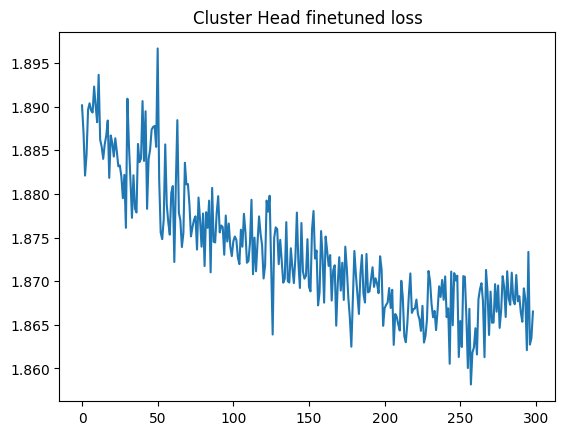

In [10]:
plt.plot(training_result["stage_two"]["clust_head_finetune_losses"])
plt.title("Cluster Head finetuned loss")
plt.show()

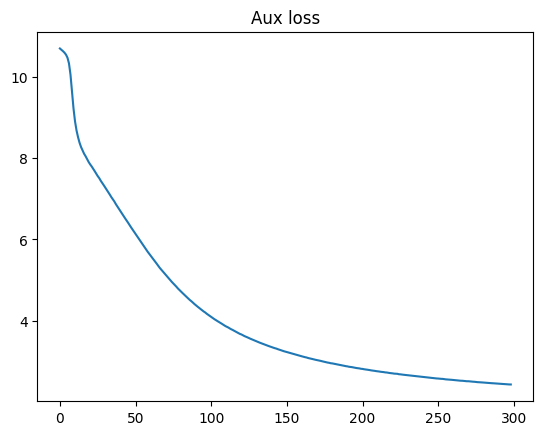

In [11]:
plt.plot(training_result["stage_two"]["aux_losses"])
plt.title("Aux loss")
plt.show()

In [12]:
with torch.no_grad():
    X = mnist_X_subset.to(device)
    X_Z ,z , _ = idc.gnn(X)
    H = idc.ae.encoder(X_Z)

    clust_logits, aux_logits, u_zg = idc.clusterNN(X_Z, H)
    yhat = clust_logits.argmax(dim=1).cpu()

    print(clustering_accuracy(yhat, mnist_y_subset))
    print(np.unique(yhat, return_counts=True))

0.7892
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1189,  871,  925, 1055,  945, 1034,  975,  823, 1012, 1171]))


In [13]:
torch.save(idc, "../models/mnist_model.pth")